In [1]:
import torch
import torch.utils.data as data
import torch.nn as nn
import torchtext
from torch.autograd import Variable
import torchvision
from torchvision import transforms, models
import torch.nn.functional as F

from tqdm.notebook import tqdm
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from PIL import Image
import os
import string
import math
import nltk

from model import EncoderCNN, DecoderRNN
from classes import COCODataset
from helper import *

In [2]:
device = torch.device("cuda: 0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# Hyperparameters

BATCH_SIZE = 32
IMG_SIZE = 224

EMBED_SIZE = 300
HIDDEN_SIZE = 300

MIN_VOCAB_FREQS = 1
MAX_VOCAB_SIZE = 20000

In [4]:
MAKE_ANNOTATION_TEXT_FILE = 0
TRAIN_DATA = 1

In [5]:
DATA_DIR = {
    "train": "data/train2017",
    "val": "data/val2017",
    "test": "data/test2017",
    "annotation": {
        "train": "data/annotations/captions_train2017.json",
        "val": "data/annotations/captions_val2017.json"}
    
}

In [6]:
traindict = process_data(DATA_DIR["annotation"]["train"])
valdict = process_data(DATA_DIR["annotation"]["val"])

TRAINING_SAMPLES = len(traindict)
print(f"Number of training samples: {TRAINING_SAMPLES} images")

data/annotations/captions_train2017.json
data/annotations/captions_val2017.json
Number of training samples: 118287 images


In [7]:
if MAKE_ANNOTATION_TEXT_FILE:
    import csv
    with open("data/train_annotation_text.csv", "w", newline="") as fi:
        writer = csv.writer(fi)
        for i in tqdm(range(len(traindict))):
            anno = list(traindict.values())[i]["captions"]
            for line in anno:
                writer.writerow([line])

In [8]:
data_transform = {
    "train": transforms.Compose([
                transforms.Resize((256,256)),
                transforms.RandomCrop((IMG_SIZE,IMG_SIZE)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
    
    "val": transforms.Compose([
                transforms.Resize((IMG_SIZE,IMG_SIZE)),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]),
}

In [9]:
trainset = COCODataset(DATA_DIR["train"],traindict,data_transform["train"])
valset = COCODataset(DATA_DIR["val"],valdict,data_transform["val"])

Vocabulary successfully loaded from vocab.pkl file!



Vocabulary successfully loaded from vocab.pkl file!


In [10]:
VOCAB_SIZE = len(trainset.vocab)
print(f"Number of unique words from the dataset: {VOCAB_SIZE} words")

Number of unique words from the dataset: 11559 words


a yellow plate with a sandwich and a serving of broccoli .


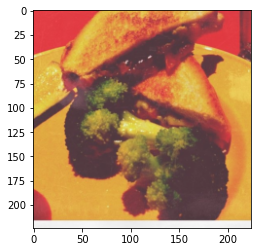

the dog is riding on the boat in the water .


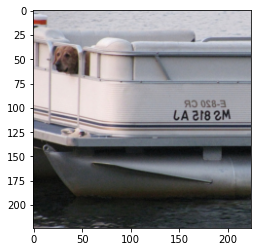

a man skateboarding on skateboards on gray pavement


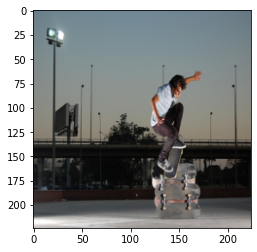

a group of people playing frisbee in the park .


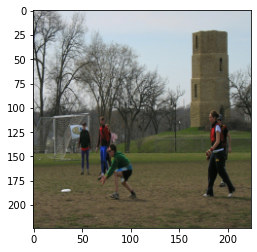

a large white airplane flying to it 's destination .


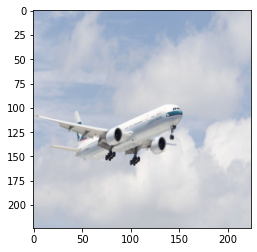

In [11]:
%matplotlib inline
def visualize_training(NUM_PIC = 5 ):
    for i in range(NUM_PIC):
        a = np.random.randint(TRAINING_SAMPLES-NUM_PIC)
        item = trainset[a]
        img_show, caps = trainset.imshow(item)
        plt.imshow(img_show)
        print(caps)
        plt.show()
visualize_training()

In [12]:
indices = trainset.get_train_indices(BATCH_SIZE)
initial_sampler = data.sampler.SubsetRandomSampler(indices=indices)
trainloader = data.DataLoader(trainset,
                              num_workers= 0, 
                             batch_sampler=data.sampler.BatchSampler(sampler=initial_sampler,
                                                                    batch_size=BATCH_SIZE,
                                                                    drop_last=False))
valloader = data.DataLoader(valset, batch_size=1, num_workers= 0)

In [13]:
from torchsummary import summary

encoder = EncoderCNN(EMBED_SIZE).to(device)
decoder = DecoderRNN(EMBED_SIZE, HIDDEN_SIZE, VOCAB_SIZE).to(device)

params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn1.parameters())
optimizer = torch.optim.Adam(params=params, lr = 1e-5)

criterion = nn.CrossEntropyLoss()

total_step = math.ceil(len(trainloader.dataset.caption_lengths) / BATCH_SIZE)
#print(encoder)
print(decoder)

DecoderRNN(
  (word_embeddings): Embedding(11559, 300)
  (linear): Linear(in_features=300, out_features=11559, bias=True)
  (lstm): LSTM(300, 300, batch_first=True)
)


In [14]:
def get_prediction(encoder,decoder):
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        a = np.random.randint(5000)
        batch = valset[a]

        imgs = batch["img"].unsqueeze(0).to(device)
        caps = batch["captions"]
        
        img_show,_ = valset.imshow(batch,train=False)
        features = encoder(imgs).unsqueeze(1)
        output = decoder.sample(features)
        sentence = valloader.dataset.clean_sentence(output)
        plt.imshow(img_show)
        plt.axis("off")
        plt.show()
        print("Generated Caption: " + sentence)
        print("Ground Truth: " + caps)
    encoder.train()
    decoder.train()

In [15]:
def train(encoder, decoder, optimizer, criterion, trainloader):
    
    EPOCHS = 3
    running_loss = 0
    #lowest_perplexity = 8.4605, hidden_dim = 100
    lowest_perplexity = 7.5
    for epoch in range(EPOCHS):
        for idx in tqdm(range(0,total_step)):
            encoder.train()
            decoder.train()
            indices = trainloader.dataset.get_train_indices(BATCH_SIZE)
            new_sampler = data.sampler.SubsetRandomSampler(indices=indices)
            trainloader.batch_sampler.sampler = new_sampler
            batchdict = next(iter(trainloader))
            
            
            decoder.zero_grad()
            encoder.zero_grad()
            
            imgs = batchdict["img"].to(device)
            caps = batchdict["captions_idx"]
        
            captions_target = caps[:, :].to(device)
            captions_train = caps.to(device)
           
            features  = encoder(imgs)
            output = decoder(features,captions_train)
           
            loss = criterion(output.view(-1, VOCAB_SIZE), captions_target.contiguous().view(-1))  
            perplexity = np.exp(loss.item())
            loss.backward()
            optimizer.step()
            
            if idx%300 == 0:
                print(f"Epoch: [{epoch+1}|{EPOCHS}] | Batch: [{idx+1}|{total_step}]")
                print(f"\tLoss: {loss.data:.4f} | Perplexity: {perplexity:.4f}")
                get_prediction(encoder,decoder)
                if perplexity < lowest_perplexity:
                    lowest_perplexity = perplexity
                    torch.save(encoder.state_dict(), "model/encoder-resnet300-2.pt")
                    torch.save(decoder.state_dict(), "model/decoder-resnet300-2.pt")
                else:
                    torch.save(encoder.state_dict(), f"model/epoch/encoder-resnet-{epoch}-{idx}.pt")
                    torch.save(decoder.state_dict(), f"model/epoch/decoder-resnet-{epoch}-{idx}.pt")
                print("Model saved!")

    return encoder, decoder

Epoch: [1|3] | Batch: [1|3697]
	Loss: 2.4955 | Perplexity: 12.1281


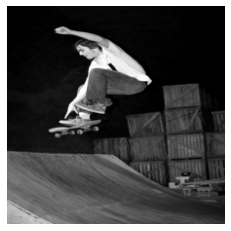

Generated Caption: A man is doing a trick on a skateboard .
Ground Truth: a male skateboarder in a white shirt is doing a trick
Model saved!
Epoch: [1|3] | Batch: [301|3697]
	Loss: 2.1838 | Perplexity: 8.8801


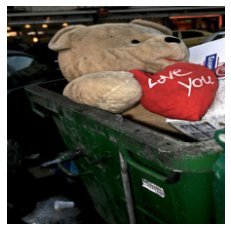

Generated Caption: A red and yellow fire hydrant sitting in a parking lot .
Ground Truth: a teddy bear inside a basket full of stuff .
Model saved!
Epoch: [1|3] | Batch: [601|3697]
	Loss: 2.2028 | Perplexity: 9.0506


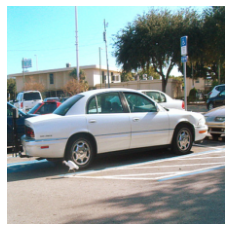

Generated Caption: A car parked on the side of a road .
Ground Truth: there is a car parked in the handicapped spot .
Model saved!
Epoch: [1|3] | Batch: [901|3697]
	Loss: 2.3269 | Perplexity: 10.2461


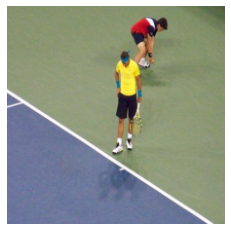

Generated Caption: A man is playing tennis on a tennis court .
Ground Truth: a tennis player grabs an extra ball from his pocket .
Model saved!
Epoch: [1|3] | Batch: [1201|3697]
	Loss: 2.1971 | Perplexity: 8.9989


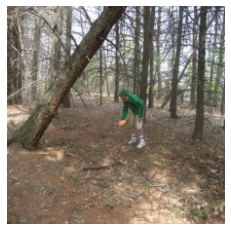

Generated Caption: A man is playing frisbee in a park .
Ground Truth: a person with a frisbe near many trees
Model saved!
Epoch: [1|3] | Batch: [1501|3697]
	Loss: 2.1809 | Perplexity: 8.8542


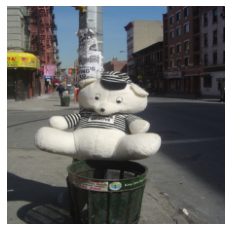

Generated Caption: A bird sitting on a bench in front of a window .
Ground Truth: a large white stuffed bear sits on a trash can .
Model saved!
Epoch: [1|3] | Batch: [1801|3697]
	Loss: 2.2248 | Perplexity: 9.2515


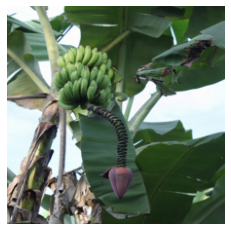

Generated Caption: A banana tree with a banana tree in it .
Ground Truth: a patch of green bananas up in a banana tree
Model saved!
Epoch: [1|3] | Batch: [2101|3697]
	Loss: 2.4787 | Perplexity: 11.9257


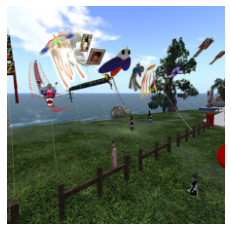

Generated Caption: A group of people flying kites in a field .
Ground Truth: a group of people flying kites of a lush green field .
Model saved!
Epoch: [1|3] | Batch: [2401|3697]
	Loss: 2.2407 | Perplexity: 9.3999


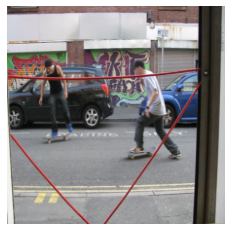

Generated Caption: A man is standing on a sidewalk with a dog .
Ground Truth: this is an image through a window looking at two people on skateboards .
Model saved!
Epoch: [1|3] | Batch: [2701|3697]
	Loss: 2.6972 | Perplexity: 14.8376


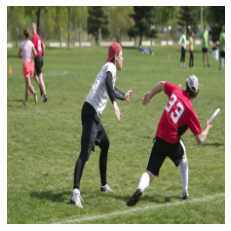

Generated Caption: A group of people playing soccer on a field .
Ground Truth: two people in an open field are playing with a frisbee .
Model saved!
Epoch: [1|3] | Batch: [3001|3697]
	Loss: 2.5801 | Perplexity: 13.1988


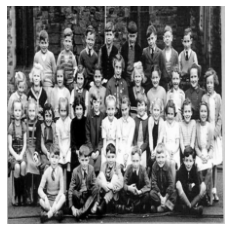

Generated Caption: A group of men standing around a baseball game .
Ground Truth: a group of children standing next to each other .
Model saved!
Epoch: [1|3] | Batch: [3301|3697]
	Loss: 2.3916 | Perplexity: 10.9310


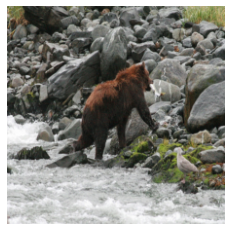

Generated Caption: A brown and white cow standing in the water .
Ground Truth: a bear is coming out of the water and onto the rocks .
Model saved!
Epoch: [1|3] | Batch: [3601|3697]
	Loss: 3.8072 | Perplexity: 45.0258


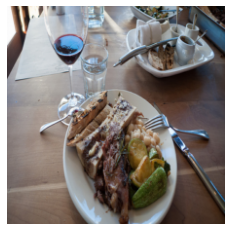

Generated Caption: A plate of food with a sandwich and a sandwich .
Ground Truth: a dinner plate with beans , bones , and veggies .
Model saved!



Epoch: [2|3] | Batch: [1|3697]
	Loss: 2.5919 | Perplexity: 13.3553


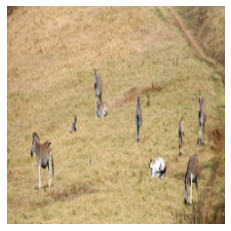

Generated Caption: A group of sheep grazing in a field .
Ground Truth: a panoramic view of zebras in a dry field .
Model saved!
Epoch: [2|3] | Batch: [301|3697]
	Loss: 2.0725 | Perplexity: 7.9446


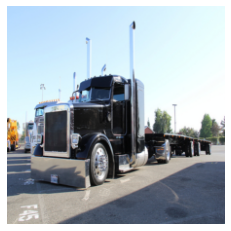

Generated Caption: A truck with a truck on it 's side .
Ground Truth: an eighteen wheeler truck is parked in a lot .
Model saved!
Epoch: [2|3] | Batch: [601|3697]
	Loss: 2.7232 | Perplexity: 15.2287


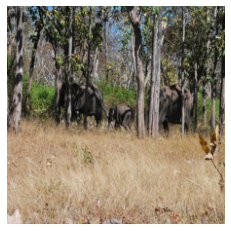

Generated Caption: A herd of elephants walking in a field .
Ground Truth: a herd of wild animals walking across a dry grass park .
Model saved!
Epoch: [2|3] | Batch: [901|3697]
	Loss: 2.2553 | Perplexity: 9.5384


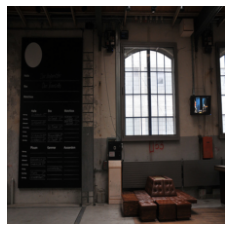

Generated Caption: A large building with a clock on it .
Ground Truth: a leather sitting bench is in a dimly lit room .
Model saved!
Epoch: [2|3] | Batch: [1201|3697]
	Loss: 2.1122 | Perplexity: 8.2663


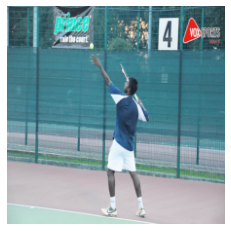

Generated Caption: A man is playing tennis on a tennis court .
Ground Truth: a young black male serving a tennis ball on a tennis court
Model saved!
Epoch: [2|3] | Batch: [1501|3697]
	Loss: 2.3615 | Perplexity: 10.6069


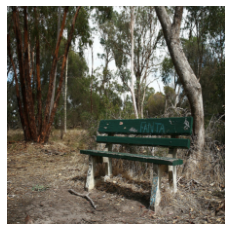

Generated Caption: A bench sitting on a bench in the woods .
Ground Truth: a park bench with graffiti sitting next to dead grass .
Model saved!
Epoch: [2|3] | Batch: [1801|3697]
	Loss: 2.8909 | Perplexity: 18.0095


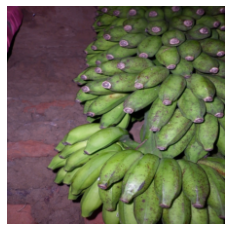

Generated Caption: A man is holding a bunch of bananas in a market .
Ground Truth: a bunch of green bananas laying on a stone table .
Model saved!
Epoch: [2|3] | Batch: [2101|3697]
	Loss: 2.2458 | Perplexity: 9.4477


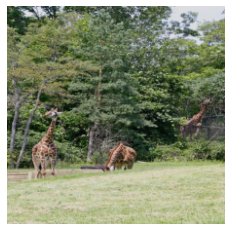

Generated Caption: A giraffe standing in a field with trees in the background .
Ground Truth: three adult giraffes in a field among trees
Model saved!
Epoch: [2|3] | Batch: [2401|3697]
	Loss: 2.5114 | Perplexity: 12.3221


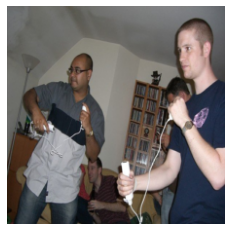

Generated Caption: A man and a woman are playing a video game .
Ground Truth: two men playing an interactive video game in a room with friends .
Model saved!
Epoch: [2|3] | Batch: [2701|3697]
	Loss: 2.1836 | Perplexity: 8.8786


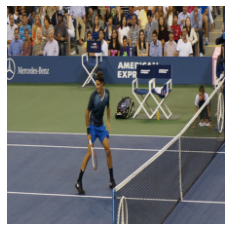

Generated Caption: A tennis player is swinging at a tennis ball .
Ground Truth: a man in black shirt and blue shorts playing tennis .
Model saved!
Epoch: [2|3] | Batch: [3001|3697]
	Loss: 2.2297 | Perplexity: 9.2971


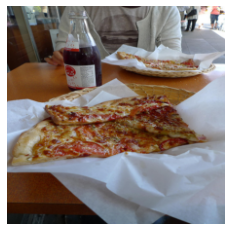

Generated Caption: A person is holding a plate of food .
Ground Truth: two plates of pizza and a drink on a wooden table
Model saved!
Epoch: [2|3] | Batch: [3301|3697]
	Loss: 1.8874 | Perplexity: 6.6022


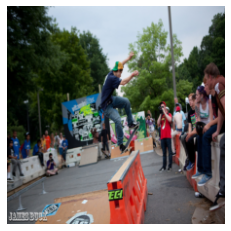

Generated Caption: A man is doing a trick on a skateboard .
Ground Truth: a man with a hat jumping a barrier with a skate board
Model saved!
Epoch: [2|3] | Batch: [3601|3697]
	Loss: 2.2398 | Perplexity: 9.3918


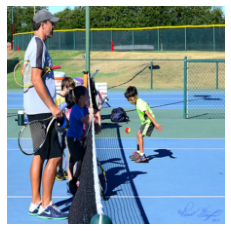

Generated Caption: A tennis player is swinging a racket at a ball .
Ground Truth: a man teaching young people how to play tennis .
Model saved!



Epoch: [3|3] | Batch: [1|3697]
	Loss: 2.2132 | Perplexity: 9.1452


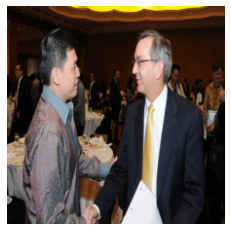

Generated Caption: A man and a woman are standing in front of a crowd .
Ground Truth: two men are shaking hands at a social gathering .
Model saved!
Epoch: [3|3] | Batch: [301|3697]
	Loss: 2.7453 | Perplexity: 15.5688


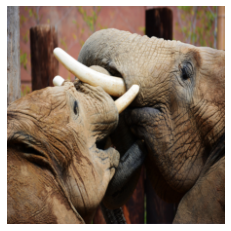

Generated Caption: A baby elephant standing next to a baby elephant .
Ground Truth: pair of elephants interacting in urban like setting .
Model saved!
Epoch: [3|3] | Batch: [601|3697]
	Loss: 2.1851 | Perplexity: 8.8918


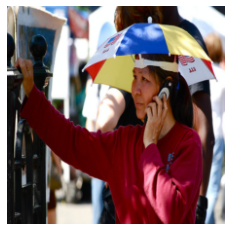

Generated Caption: A woman holding a cell phone in her hand .
Ground Truth: a woman with an umbrella hat on talking on a cell phone .
Model saved!
Epoch: [3|3] | Batch: [901|3697]
	Loss: 2.3159 | Perplexity: 10.1342


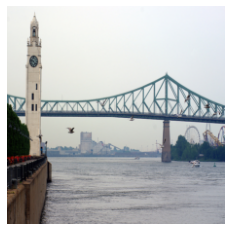

Generated Caption: A boat is docked at a dock with a boat in the background
Ground Truth: beautiful scene of the water , the bridge , and a tall clock tower
Model saved!
Epoch: [3|3] | Batch: [1201|3697]
	Loss: 2.3715 | Perplexity: 10.7129


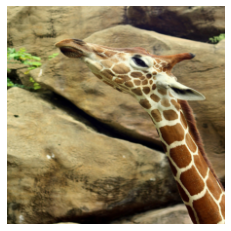

Generated Caption: A giraffe is standing in a field of grass .
Ground Truth: a giraffe in the display at the zoo .
Model saved!
Epoch: [3|3] | Batch: [1501|3697]
	Loss: 2.4574 | Perplexity: 11.6743


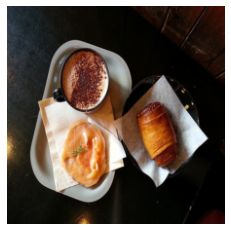

Generated Caption: A plate of food with a sandwich and a drink .
Ground Truth: breakfast foods served on a tray on a table .
Model saved!
Epoch: [3|3] | Batch: [1801|3697]
	Loss: 2.3106 | Perplexity: 10.0804


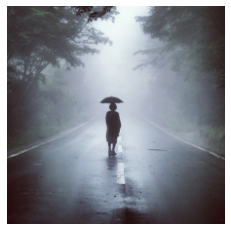

Generated Caption: A man riding a skateboard down a street .
Ground Truth: a person holds an umbrella in the middle of a rode .
Model saved!
Epoch: [3|3] | Batch: [2101|3697]
	Loss: 3.0103 | Perplexity: 20.2928


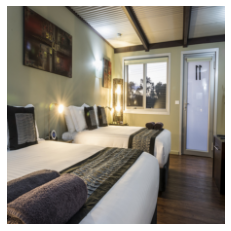

Generated Caption: A living room with a couch , a table , and a television .
Ground Truth: a hotel room with two beds side by side .
Model saved!
Epoch: [3|3] | Batch: [2401|3697]
	Loss: 2.4128 | Perplexity: 11.1656


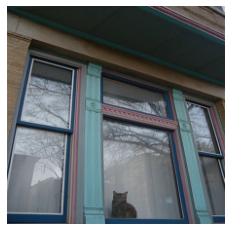

Generated Caption: A window of a car with a clock on the side .
Ground Truth: a black cat sitting in the window sill
Model saved!
Epoch: [3|3] | Batch: [2701|3697]
	Loss: 2.3893 | Perplexity: 10.9063


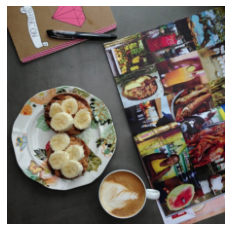

Generated Caption: A table with a bunch of food on it
Ground Truth: a table that has a plate of food on it
Model saved!
Epoch: [3|3] | Batch: [3001|3697]
	Loss: 2.3228 | Perplexity: 10.2043


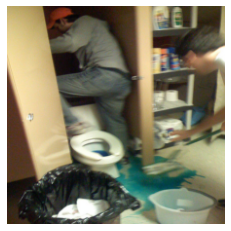

Generated Caption: A man in a bathroom with a toilet and a sink .
Ground Truth: a man with his foot on a toilet and a man holding something in his hand
Model saved!
Epoch: [3|3] | Batch: [3301|3697]
	Loss: 2.0792 | Perplexity: 7.9977


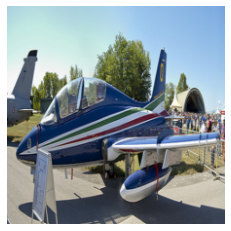

Generated Caption: A large airplane is parked on a runway .
Ground Truth: a jet fighter style airplane parked near a crowd of people who are walking about .
Model saved!
Epoch: [3|3] | Batch: [3601|3697]
	Loss: 2.2082 | Perplexity: 9.0991


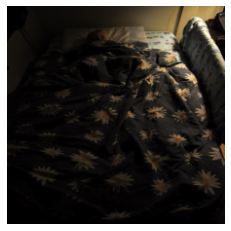

Generated Caption: A person is holding a stuffed animal on a bed .
Ground Truth: a person in a bed with a dark bedspread with flowers .
Model saved!



In [16]:
if TRAIN_DATA:
    encoder.load_state_dict(torch.load("model/encoder-resnet300.pt"))
    decoder.load_state_dict(torch.load("model/decoder-resnet300.pt"))
    encoder, decoder = train(encoder, decoder, optimizer, criterion, trainloader)

In [17]:
if not TRAIN_DATA:
    encoder.load_state_dict(torch.load("model/encoder-resnet300.pt"))
    decoder.load_state_dict(torch.load("model/decoder-resnet300.pt"))

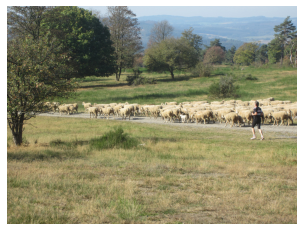

Generated Caption: A herd of sheep grazing on a grassy field .


In [28]:
def predict_single(encoder, decoder):
    a = np.random.randint(5000)
    path = os.listdir(DATA_DIR["val"])[a]
    img = Image.open(os.path.join(DATA_DIR["val"], path))
    plt.axis("off")
    plt.imshow(img)
    plt.show()
    img = data_transform["val"](img)
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        img = img.unsqueeze(0).to(device)
        
        features = encoder(img).unsqueeze(1)
        output = decoder.sample(features,max_len = 20)    
        sentence = trainloader.dataset.clean_sentence(output)
        print("Generated Caption: " + sentence)
        
        
predict_single(encoder,decoder)